# **Final Project**

Yael Zorea - 209308675

Ilay Yoeli - 318260965

Yarden Greenpeter - 318517653

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import MNIST, CIFAR10, FashionMNIST
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset, Dataset
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# Hyperparameters
learning_rate = 0.01
batch_size = 1024 # large batchsize for inference is recommended
number_of_epochs = 5
base_temperature = 1.5 # Initial temperature parameter for temperature scaling
boundary_threshold = 0.85
is_training = False  # Set to False for training, True for evaluation only

In [3]:
# OSR Dataset template
class CombinedDataset(Dataset):
    def __init__(self, mnist, ood, transform_mnist=None, transform_ood=None):
        self.mnist = mnist
        self.ood = ood
        # transforms could be defined either here or when you init each dataset.
        self.transform_mnist = transform_mnist
        self.transform_ood = transform_ood

    def __len__(self):
        # combined length of MNIST and OOD
        return len(self.mnist) + len(self.ood)

    def __getitem__(self, idx):
        if idx < len(self.mnist):
            # if index is within the range of MNIST, return MNIST data and label
            data, label = self.mnist[idx]
            if self.transform_mnist:
                data = self.transform_mnist(data)
            return data, label
        else:
            # if index is beyond the range of MNIST, return OOD data and 10 as label
            data, _ = self.ood[idx - len(self.mnist)]  # adjust index for OOD
            if self.transform_ood:
                data = self.transform_ood(data)
            return data, 10  # OOD label is always 10


# Load the MNIST and OOD datasets
# Define the transformations
mnist_train_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: x + 0.5 * torch.randn_like(x))  # Gaussian noise
])

mnist_test_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

ood_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0], std=[1])
])

mnist_train = MNIST(root='./data', train=False, download=True, transform=mnist_train_transform)
mnist_test = MNIST(root='./data', train=False, download=True, transform=mnist_test_transform)
ood = FashionMNIST(root='./data', train=False, download=True, transform=ood_transform)

# Split training data into train and validation sets
train_size = int(0.8 * len(mnist_train))
val_size = len(mnist_train) - train_size
train_dataset, val_dataset = random_split(mnist_train, [train_size, val_size])

# Combine the datasets
combined_ds = CombinedDataset(mnist_test, ood)
# Create data loaders
comb_test_data_loader = DataLoader(combined_ds, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
mnist_test_data_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 36139719.24it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1062323.57it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9122290.73it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1835311.06it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 26421880/26421880 [00:01<00:00, 13225414.69it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 269014.04it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4995021.88it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5700178.72it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
# Base model
class BaselineAutoencoder(nn.Module):
    def __init__(self):
        super(BaselineAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # 7x7
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),  # 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(128, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

        # Classifier
        self.classifier = nn.Linear(128, 10)  # 10 digits

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        classified = self.classifier(encoded)
        return decoded, encoded, classified


def train_base_model(model, train_loader, val_loader, num_epochs):
      print("Training base model")
      model.to(device)
      loss_weight = 0.8
      reconstruction_criterion = nn.MSELoss()
      classification_criterion = nn.CrossEntropyLoss()
      optimizer = optim.Adam(model.parameters(), lr=learning_rate)

      for epoch in range(num_epochs):
          model.train()
          train_loss = 0.0
          train_correct = 0
          train_total = 0
          for batch in train_loader:
              inputs, labels = batch
              inputs, labels = inputs.to(device), labels.to(device)
              optimizer.zero_grad()
              reconstructed, embedded, classified = model(inputs)
              reconstruction_loss = reconstruction_criterion(reconstructed, inputs)
              classification_loss = classification_criterion(classified, labels)
              loss = (1-loss_weight)*reconstruction_loss + loss_weight*classification_loss
              loss.backward()
              optimizer.step()
              train_loss += loss.item()

              # Calculate accuracy
              _, predicted = torch.max(classified.data, 1)
              train_total += labels.size(0)
              train_correct += (predicted == labels).sum().item()

          train_accuracy = train_correct / train_total

          # Validation
          model.eval()
          val_loss = 0.0
          val_correct = 0
          val_total = 0
          with torch.no_grad():
              for batch in val_loader:
                  inputs, labels = batch
                  inputs, labels = inputs.to(device), labels.to(device)
                  reconstructed, embedded, classified = model(inputs)
                  reconstruction_loss = reconstruction_criterion(reconstructed, inputs)
                  classification_loss = classification_criterion(classified, labels)
                  loss = (1-loss_weight)*reconstruction_loss + loss_weight*classification_loss
                  val_loss += loss.item()

                  # Calculate accuracy
                  _, predicted = torch.max(classified.data, 1)
                  val_total += labels.size(0)
                  val_correct += (predicted == labels).sum().item()

          val_accuracy = val_correct / val_total

          print(f"Epoch {epoch+1}/{num_epochs}")
          print(f"Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy*100:.2f}%")
          print(f"Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy*100:.2f}%")
          print("--------------------")

In [5]:
# Evaluation function for mnist (computer ex 1)
def evaluate_mnist(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            reconstructed, embedded, classified = model(inputs)
            _, predicted = torch.max(classified.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy()) # concat
            all_labels.extend(labels.cpu().numpy()) # concat

    accuracy = correct / total
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return accuracy, conf_matrix

In [6]:
class TemperatureScalingModel(torch.nn.Module):
    def __init__(self, model, base_temperature):
        super(TemperatureScalingModel, self).__init__()
        self.model = model
        self.temperature = torch.nn.Parameter(torch.ones(1) * base_temperature)

    def forward(self, input):
        decoded, encoded, logits = self.model(input)
        return decoded, encoded, self.temperature_scale(logits)

    def temperature_scale(self, logits):
        # Scale the logits by dividing by the learned temperature parameter
        return logits / self.temperature

    def predict(self, input):
        decoded, encoded, logits = self.model(input)
        calibrated_logits = self.temperature_scale(logits)
        return decoded, encoded, F.softmax(calibrated_logits, dim=1)  # Return calibrated probabilities

def temperature_scaling_calibration(model, data_loader, val_loader, criterion, optimizer, epoches=15):
      print("Temperature Scaling Calibration")
      model.train()
      model.to(device)
      loss_arr = []
      base_accuracy, _ = evaluate_mnist(model.model, val_loader)
      print(f"Base Accuracy on validation set: {base_accuracy*100:.2f}%")
      for epoch in tqdm(range(1, epoches+1)):  # Iterate over a few epochs to find the best temperature
          running_loss = 0.0
          for inputs, labels in data_loader:
              inputs, labels = inputs.to(device), labels.to(device)

              optimizer.zero_grad()
              _, _, logits = model(inputs)

              loss = criterion(logits, labels)
              loss.backward()
              optimizer.step()
              running_loss += loss.item()

          loss_arr.append(running_loss/len(data_loader))
          # Calculate accuracy on validation, to verify the calibration didn't hurt the base model preformance
          if epoch % 5 == 0:
              accuracy, _ = evaluate_mnist(model, val_loader)
              print(f'Epoch [{epoch}/{epoches}], Calibration Loss: {running_loss/len(data_loader)}, Validation Accuracy after scaling: {accuracy*100:.2f}%')

      return loss_arr

In [7]:
def eval_model(model, data_loader, device, threshold):
    """ Evaluation function for the OSR task.
    Given your OSR predictions, comptues the accuracy on MNIST, OOD set and both.
    Note - this function does NOT computes the MNIST baseline accruacy.
    Returns:
     - acc_mnist
     - acc_ood
     - acc_total
    """

    # Ensure model is in evaluation mode
    model.eval()

    correct_mnist = 0
    total_mnist = 0
    correct_ood = 0
    total_ood = 0

    # Initialize lists to store predicted and true labels for confusion matrix
    all_preds = []
    all_labels = []
    all_original_predictions = []
    all_data = []

    # misclassified_ood_as_digit = []

    # No need to track gradients for evaluation, saves memory and computations
    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)

            ### Modify output if needed ###
            _, _, probabilities = model.predict(data)
            # Get the maximum probability for each image in the batch
            max_probs, predicted = torch.max(probabilities, dim=1)
            # Classify images with low confidence (max_probs < threshold) as label 10
            unknown = (max_probs < threshold)
            predicted[unknown] = 10
            # Check for OOD samples misclassified as digit
            # ood_mask = labels == 10
            # misclassified_mask = (predicted == 4) & ood_mask
            # misclassified_ood_as_digit.extend(data[misclassified_mask].cpu())

            # y pred should be a vector of size (N_batch,) -> [5, 2, ..., 10]
            # and not one-hot. You can handle this either in your model or here.

            # Assuming the model returns an (N_batch, 11) size output
            # probas, y_pred = torch.max(outputs, 1)

            # Assuming the model retuns the predicted label (N_batch, )
	          # y_pred = outputs

            # Split MNIST and OOD predictions and labels
            # Assuming numerical labels, which is MNIST/CIFAR datasets default
            # Note: Not one-hot!
            mask_mnist = labels < 10
            mask_ood = ~mask_mnist
            labels_mnist = labels[mask_mnist]
            labels_ood = labels[mask_ood]

            pred_mnist = predicted[mask_mnist]
            pred_ood = predicted[mask_ood]

            total_mnist += labels_mnist.size(0)
            total_ood += labels_ood.size(0)
            correct_mnist += (pred_mnist == labels_mnist).sum().item()
            correct_ood += (pred_ood == labels_ood).sum().item()

            # Store predicted and true labels for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc_mnist = correct_mnist / total_mnist
    acc_ood = correct_ood / total_ood
    acc_total = (correct_mnist + correct_ood) / (total_mnist + total_ood)

    return acc_mnist, acc_ood, acc_total, np.array(all_preds), np.array(all_labels)#, misclassified_ood_as_digit

Training base model
Epoch 1/5
Train Loss: 1.6052, Train Accuracy: 40.84%
Val Loss: 1.0938, Val Accuracy: 65.25%
--------------------
Epoch 2/5
Train Loss: 0.7360, Train Accuracy: 79.11%
Val Loss: 0.5310, Val Accuracy: 87.25%
--------------------
Epoch 3/5
Train Loss: 0.4309, Train Accuracy: 91.14%
Val Loss: 0.4053, Val Accuracy: 91.85%
--------------------
Epoch 4/5
Train Loss: 0.3316, Train Accuracy: 94.38%
Val Loss: 0.3244, Val Accuracy: 93.95%
--------------------
Epoch 5/5
Train Loss: 0.2701, Train Accuracy: 96.49%
Val Loss: 0.3089, Val Accuracy: 94.75%
--------------------

Temperature Scaling Calibration
Base Accuracy on validation set: 95.00%


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [5/15], Calibration Loss: 0.11716610565781593, Validation Accuracy after scaling: 95.10%
Epoch [10/15], Calibration Loss: 0.12213141843676567, Validation Accuracy after scaling: 95.00%
Epoch [15/15], Calibration Loss: 0.11748761031776667, Validation Accuracy after scaling: 95.05%


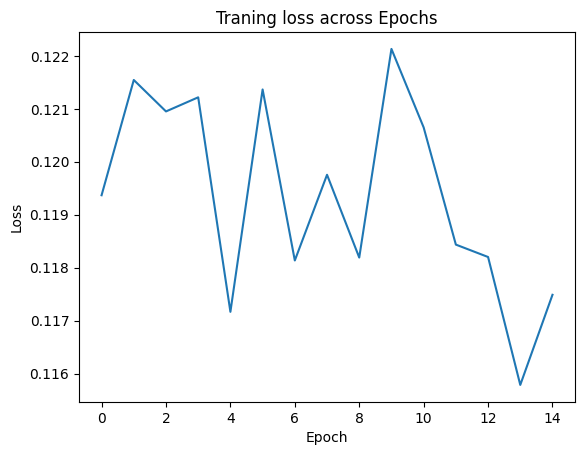

In [8]:
# Train handeling

if is_training: # Load the relevant weights and only perform evaluation
    print("Loading models")
    base_model = BaselineAutoencoder()
    calibrated_model = TemperatureScalingModel(base_model, base_temperature)
    calibrated_model.load_state_dict(torch.load('calibrated_model_weights.pth'))
    calibrated_model.to(device)

else: # Need to train the models
    base_model = BaselineAutoencoder()
    train_base_model(base_model, train_loader, val_loader, number_of_epochs)
    print()
    calibrated_model = TemperatureScalingModel(base_model, base_temperature)
    criterion_calib = torch.nn.CrossEntropyLoss()
    optimizer_calib = torch.optim.Adam([calibrated_model.temperature], lr=learning_rate*0.05)
    for param in base_model.parameters():
          param.requires_grad = False # "Freez" the weights of the base model
    calib_loss = temperature_scaling_calibration(calibrated_model, train_loader, val_loader, criterion_calib, optimizer_calib)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Traning loss across Epochs')
    plt.plot(calib_loss)
    plt.show()
    torch.save(calibrated_model.state_dict(), 'calibrated_model_weights.pth')


Baseline Accuracy on MNIST test set: 97.33%



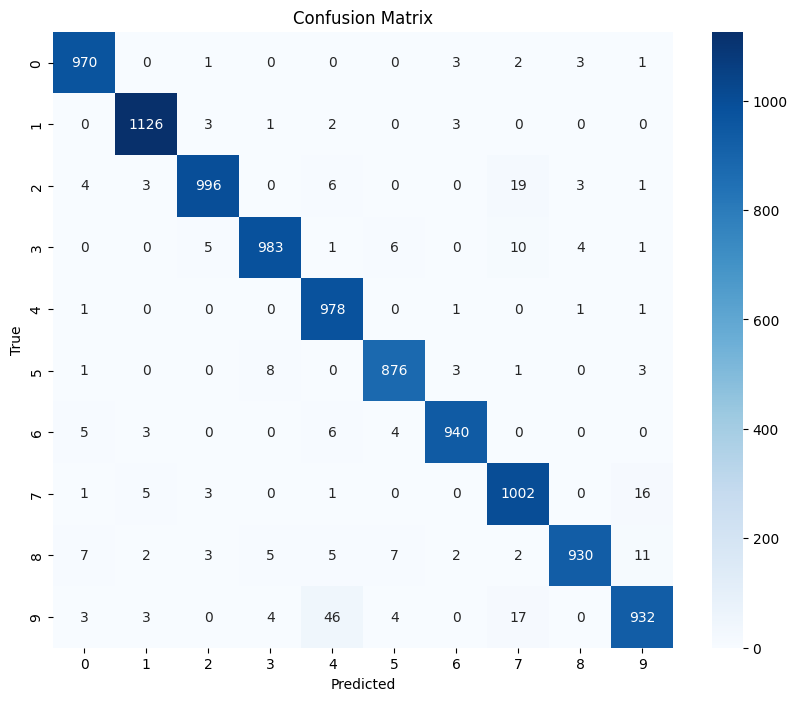

In [9]:
# Evaluate the basic model (Computer Exercise 1)
accuracy, conf_matrix = evaluate_mnist(base_model, mnist_test_data_loader)
print(f"Baseline Accuracy on MNIST test set: {accuracy*100:.2f}%")
print()

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

MNIST Accuracy: 89.91%
OOD Accuracy: 99.98%
Total Accuracy: 94.95%



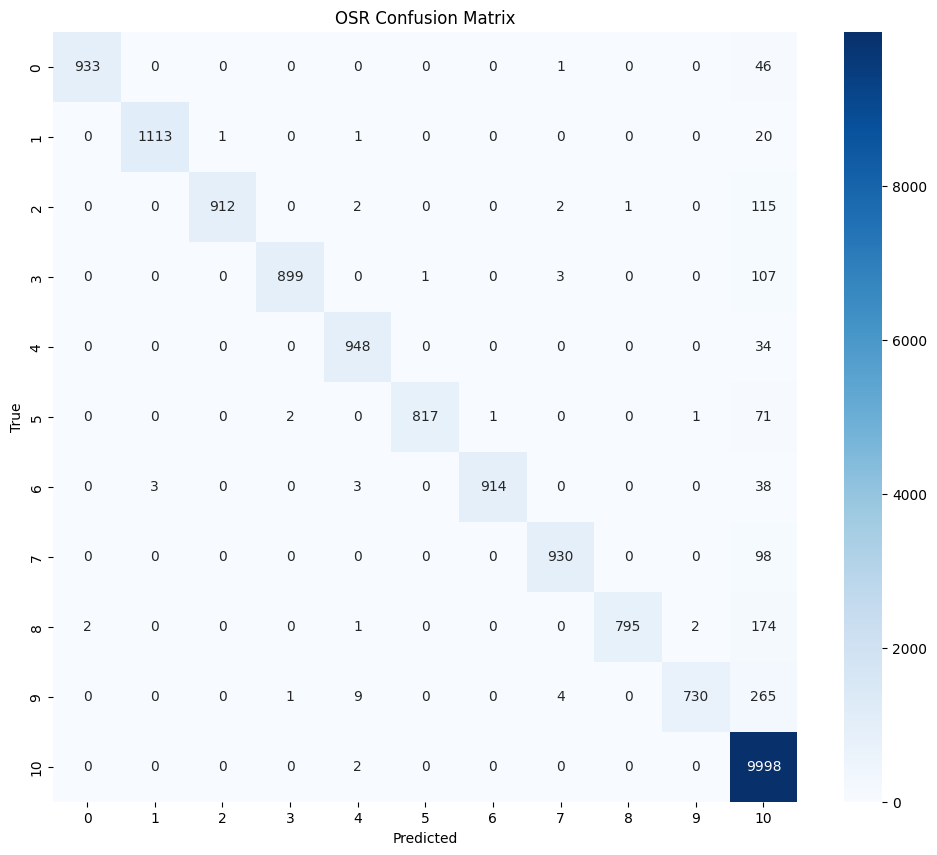

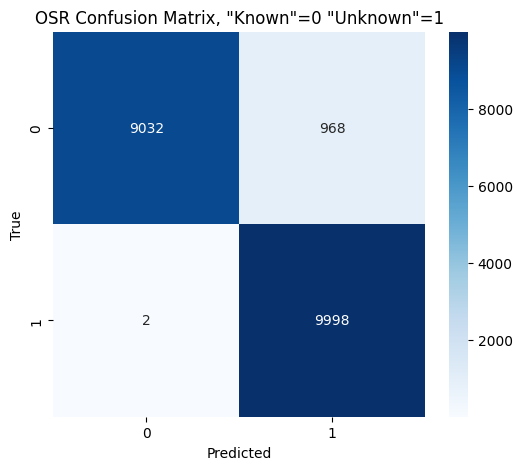

In [10]:
# Classify samples as known or unknown (Computer Exercise 2)
acc_mnist, acc_ood, acc_total, osr_preds, osr_labels = eval_model(calibrated_model, comb_test_data_loader, device, boundary_threshold)
print(f'MNIST Accuracy: {acc_mnist*100:.2f}%')
print(f'OOD Accuracy: {acc_ood*100:.2f}%')
print(f'Total Accuracy: {acc_total*100:.2f}%')
print()

# Plot OSR confusion matrix
osr_conf_matrix = confusion_matrix(osr_labels, osr_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(osr_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('OSR Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print()

osr_preds[osr_preds <= 9] = 0
osr_preds[osr_preds == 10] = 1
osr_labels[osr_labels <= 9] = 0
osr_labels[osr_labels == 10] = 1

osr_conf_matrix = confusion_matrix(osr_labels, osr_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(osr_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('OSR Confusion Matrix, "Known"=0 "Unknown"=1')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [11]:
# # Visualize up to 5 OOD images misclassified as digit
# digit = 4
# num_images = min(5, len(misclassified_ood_as_digit))
# if num_images > 0:
#     plt.figure(figsize=(15, 3))
#     for i in range(num_images):
#         plt.subplot(1, 5, i+1)
#         plt.imshow(misclassified_ood_as_digit[i].squeeze(), cmap='gray')
#         plt.title(f'OOD as {digit} ({i+1})')
#         plt.axis('off')
#     plt.suptitle(f'OOD Images Misclassified as Digit {digit}')
#     plt.show()
# else:
#     print(f"No OOD images were misclassified as digit {digit}.")